# **Classification with Random Forest Classifier in Python**


### Installing required libraries


In [1]:
%%capture
#pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 seaborn==0.13.2 scikit-learn==1.5.0 xlrd==2.0.1 openpyxl==3.1.4

### Importing required libraries


In [37]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.utils import resample

sns.set_context('notebook')
sns.set_style('white')

## Load the data

The data set that i'll use is about classifying patients into diabetes positive or negative given their medical information such as their cholesterol, glucose levels, age, gender, height, waist, and hip measurements. This data set was taken from: [data.world](https://data.world/search?q=diabetes+classification).


In [3]:
# Read the dataset
df = pd.read_excel('Diabetes_Classification (1).xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Patient number   390 non-null    int64  
 1   Cholesterol      390 non-null    int64  
 2   Glucose          390 non-null    int64  
 3   HDL Chol         390 non-null    int64  
 4   Chol/HDL ratio   390 non-null    float64
 5   Age              390 non-null    int64  
 6   Gender           390 non-null    object 
 7   Height           390 non-null    int64  
 8   Weight           390 non-null    int64  
 9   BMI              390 non-null    float64
 10  Systolic BP      390 non-null    int64  
 11  Diastolic BP     390 non-null    int64  
 12  waist            390 non-null    int64  
 13  hip              390 non-null    int64  
 14  Waist/hip ratio  390 non-null    float64
 15  Diabetes         390 non-null    object 
 16  Unnamed: 16      1 non-null      float64
 17  Unnamed: 17     

In [4]:
df.head()

,Patient number,Cholesterol,Glucose,HDL Chol,Chol/HDL ratio,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Waist/hip ratio,Diabetes,Unnamed: 16,Unnamed: 17
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes,6.0,6.0
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes,NaN,NaN
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes,NaN,NaN
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes,NaN,NaN
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes,NaN,NaN


The last two columns are not relevant. You can remove them.


In [5]:
df.drop(columns=['Unnamed: 16', 'Unnamed: 17'])

,Patient number,Cholesterol,Glucose,HDL Chol,Chol/HDL ratio,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Waist/hip ratio,Diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,227,105,44,5.2,83,female,59,125,25.2,150,90,35,40,0.88,No diabetes
386,387,226,279,52,4.3,84,female,60,192,37.5,144,88,41,48,0.85,Diabetes
387,388,301,90,118,2.6,89,female,61,115,21.7,218,90,31,41,0.76,No diabetes
388,389,232,184,114,2.0,91,female,61,127,24.0,170,82,35,38,0.92,Diabetes


In [6]:
# proportion of patients with and without diabetes
frequency_table = df['Diabetes'].value_counts()
props = frequency_table.apply(lambda x: x / len(df['Diabetes']))
print(props)

Diabetes
No diabetes    0.846154
Diabetes       0.153846
Name: count, dtype: float64


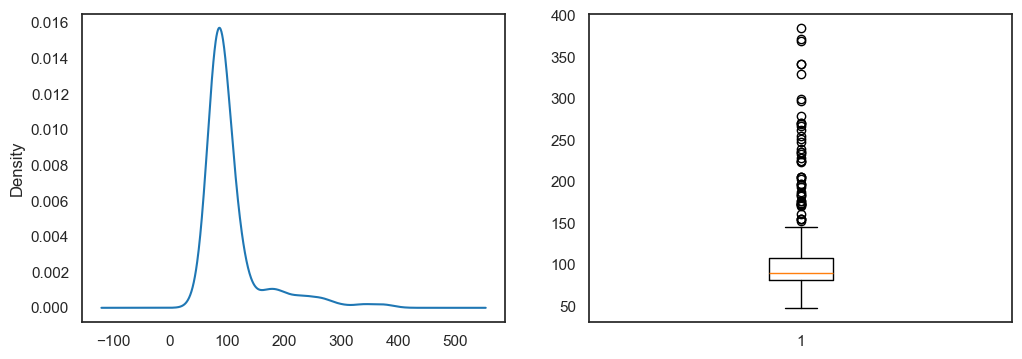

In [7]:
# Detecting Outliers
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['Glucose'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(df['Glucose'])
plt.show()

In [8]:
# Reduce dataframe dengan cara membuat data dengan kolom yang akan digunakan saja
df_reduced = df[["Diabetes", "Cholesterol", "Glucose", "BMI", "Waist/hip ratio", "HDL Chol", "Chol/HDL ratio", "Systolic BP", "Diastolic BP", "Weight"]]

numerical_columns = df_reduced.iloc[:, 1:10]

# Scaling data yang sudah direduce
scaler = StandardScaler()
preproc_reduced = scaler.fit(numerical_columns)

df_standardized = preproc_reduced.transform(numerical_columns)

# Converting the standardized array back to DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=numerical_columns.columns)
df_standardized

,Cholesterol,Glucose,BMI,Waist/hip ratio,HDL Chol,Chol/HDL ratio,Systolic BP,Diastolic BP,Weight
0,-0.319013,-0.564655,-0.951944,-0.565995,-0.073401,-0.360132,-0.838071,-0.985822,-1.447312
1,-1.372619,-0.527432,-0.360358,-0.702760,-0.536983,-0.533102,-1.276087,-1.875972,-1.050840
2,0.218998,-0.601879,0.079539,0.117828,0.216339,-0.302476,-1.188484,-0.837464,0.237692
3,0.420753,-0.192418,-1.391841,-1.249818,1.143504,-0.763729,-0.662865,-1.430897,-1.571209
4,-0.969111,-0.304089,-1.300828,-0.839524,0.969660,-1.224982,-0.662865,0.201045,-0.902163
...,...,...,...,...,...,...,...,...,...
385,0.443170,-0.043523,-0.542385,-0.018937,-0.363140,0.389404,0.563581,0.497761,-1.298635
386,0.420753,3.194941,1.323387,-0.429231,0.100443,-0.129506,0.300771,0.349403,0.361590
387,2.102039,-0.322701,-1.073295,-1.660112,3.924999,-1.109668,3.542092,0.497761,-1.546430
388,0.555256,1.426814,-0.724411,0.528122,3.693208,-1.455608,1.439613,-0.095672,-1.249076


In [9]:
df_standardized.describe()

,Cholesterol,Glucose,BMI,Waist/hip ratio,HDL Chol,Chol/HDL ratio,Systolic BP,Diastolic BP,Weight
count,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02,3.900000e+02
mean,7.287618e-17,-1.457524e-16,2.277381e-17,-6.741046e-16,4.327023e-17,-6.376666e-17,2.915047e-16,-3.006142e-16,-1.867452e-16
std,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00,1.001285e+00
min,-2.896986e+00,-1.104399e+00,-2.059272e+00,-2.754229e+00,-2.217470e+00,-1.743891e+00,-2.064517e+00,-2.617764e+00,-1.942901e+00
25%,-6.328534e-01,-4.902078e-01,-7.092421e-01,-7.027598e-01,-7.108267e-01,-7.637287e-01,-6.628646e-01,-6.149262e-01,-6.729533e-01
50%,-9.484179e-02,-3.227011e-01,-1.479938e-01,-1.893664e-02,-2.472441e-01,-1.871623e-01,-4.964184e-02,-9.567210e-02,-1.092203e-01
75%,4.880041e-01,7.659498e-03,5.308134e-01,6.648866e-01,5.060777e-01,5.047173e-01,4.759777e-01,4.977612e-01,5.598254e-01
max,5.285274e+00,5.167799e+00,4.099291e+00,3.536944e+00,4.040895e+00,8.518990e+00,4.943744e+00,3.019853e+00,3.657259e+00


put everything in a data frame called `df_stize` and also have the labelled target (Diabetes).


In [10]:
df_stdize = pd.concat([df_reduced['Diabetes'], df_standardized], axis=1)
df_stdize

,Diabetes,Cholesterol,Glucose,BMI,Waist/hip ratio,HDL Chol,Chol/HDL ratio,Systolic BP,Diastolic BP,Weight
0,No diabetes,-0.319013,-0.564655,-0.951944,-0.565995,-0.073401,-0.360132,-0.838071,-0.985822,-1.447312
1,No diabetes,-1.372619,-0.527432,-0.360358,-0.702760,-0.536983,-0.533102,-1.276087,-1.875972,-1.050840
2,No diabetes,0.218998,-0.601879,0.079539,0.117828,0.216339,-0.302476,-1.188484,-0.837464,0.237692
3,No diabetes,0.420753,-0.192418,-1.391841,-1.249818,1.143504,-0.763729,-0.662865,-1.430897,-1.571209
4,No diabetes,-0.969111,-0.304089,-1.300828,-0.839524,0.969660,-1.224982,-0.662865,0.201045,-0.902163
...,...,...,...,...,...,...,...,...,...,...
385,No diabetes,0.443170,-0.043523,-0.542385,-0.018937,-0.363140,0.389404,0.563581,0.497761,-1.298635
386,Diabetes,0.420753,3.194941,1.323387,-0.429231,0.100443,-0.129506,0.300771,0.349403,0.361590
387,No diabetes,2.102039,-0.322701,-1.073295,-1.660112,3.924999,-1.109668,3.542092,0.497761,-1.546430
388,Diabetes,0.555256,1.426814,-0.724411,0.528122,3.693208,-1.455608,1.439613,-0.095672,-1.249076


## Split the data set


X is all of the features for the classification, which is all of the columns except the `Diabetes` column. Alternatively, target y is the `Diabetes` column.


In [11]:
X = df_stdize.drop(columns=['Diabetes'])
y = df_stdize['Diabetes']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encode those label into 0 and 1 because KNN requires numerical input. 


In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [13]:
# Ubah label menjadi nilai biner
y_train = y_train.map({'No diabetes': 0, 'Diabetes': 1})
y_test = y_test.map({'No diabetes': 0, 'Diabetes': 1})


AttributeError: 'numpy.ndarray' object has no attribute 'map'

----------BEFORE------------
DecisionTreeClassifier Acc Train: [], 1 of KFold 5
DecisionTreeClassifier Acc Test: [], 1 of KFold 5
DecisionTreeClassifier Recall: [], 1 of KFold 5
DecisionTreeClassifier Precission: [], 1 of KFold 5
DecisionTreeClassifier AUC: [], 1 of KFold 5
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: [1.0], 1 of KFold 5
DecisionTreeClassifier Acc Test: [0.9102564102564102], 1 of KFold 5
DecisionTreeClassifier Recall: [0.75], 1 of KFold 5
DecisionTreeClassifier Precission: [0.6923076923076923], 1 of KFold 5
DecisionTreeClassifier AUC: [0.8446969696969697], 1 of KFold 5
---------------------------
----------BEFORE------------
DecisionTreeClassifier Acc Train: [1.0], 2 of KFold 5
DecisionTreeClassifier Acc Test: [0.9102564102564102], 2 of KFold 5
DecisionTreeClassifier Recall: [0.75], 2 of KFold 5
DecisionTreeClassifier Precission: [0.6923076923076923], 2 of KFold 5
DecisionTreeClassifier AUC: [0.8446969696969697], 2 of KFold 

In [ ]:
# Compare model
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['Accuracy training'] = datatr
data_hasil['Accuracy test'] = datasc
data_hasil['Precision'] = Precision
data_hasil['Recall']= Recall
data_hasil['AUC']=auc
data_hasil['gap'] = abs(data_hasil['Accuracy training'] - data_hasil['Accuracy test'])
data_hasil

,model,Accuracy training,Accuracy test,Precision,Recall,AUC,gap
0,DecisionTreeClassifier,1.000000,0.876923,0.646081,0.550000,0.743182,0.123077
1,LogisticRegression,0.925000,0.920513,0.901732,0.566667,0.775758,0.004487
2,KNeighborsClassifier,0.921795,0.912821,0.946667,0.466667,0.730303,0.008974
3,GaussianNB,0.926282,0.910256,0.745714,0.650000,0.803788,0.016026
4,RandomForestClassifier,1.000000,0.912821,0.837179,0.583333,0.778030,0.087179
5,ExtraTreesClassifier,1.000000,0.905128,0.826190,0.550000,0.759848,0.094872
6,XGBClassifier,1.000000,0.910256,0.767033,0.666667,0.810606,0.089744


## Fit the KNN model


In [ ]:
# Create a KNN classifier
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

#calculate overall accuracy
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 88.46%


## Hyperparameter tuning


## ANOVA for feature selection


Which features are the most important when classifying patients. ANOVA, which stands for Analysis of Variance, is a statistical method that is used to compare means across multiple groups to determine if there are any statistically significant differences between the means of these groups (glucose, cholesterol, weight, BMI, and so on). It assumes that there are no differences between the group means, and results from the hypothesis testing will tell you whether or a specific feature is significant.


In [ ]:
fs_score, fs_p_value = f_classif(X, y)

# Combine scores with feature names
fs_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': fs_score, 'P-Value': fs_p_value})
fs_scores = fs_scores.sort_values(by='F-Score', ascending=False)

print(fs_scores)

           Feature     F-Score       P-Value
1          Glucose  350.809177  3.205119e-56
5   Chol/HDL ratio   31.242678  4.298115e-08
0      Cholesterol   16.893380  4.827353e-05
6      Systolic BP   15.931795  7.853024e-05
3  Waist/hip ratio   12.348083  4.935038e-04
8           Weight   10.588454  1.237749e-03
2              BMI    8.365055  4.040512e-03
4         HDL Chol    5.973355  1.496812e-02
7     Diastolic BP    0.947292  3.310160e-01


'Glucose' is the most important feature in data set for predicting diabetes because its p-value is the smallest (and its F-Score is the highest).


## Downsampling


Begin by downsampling data set as well as having the same number of rows for diabetes positive and negative patients.


In [16]:
# Converting Diabetes column into binary (0 for No Diabetes and 1 for Diabetes)
df_stdize['Diabetes'] = np.where(df_stdize['Diabetes'] == 'Diabetes', 1, 0)
df_stdize

,Diabetes,Cholesterol,Glucose,BMI,Waist/hip ratio,HDL Chol,Chol/HDL ratio,Systolic BP,Diastolic BP,Weight
0,0,-0.319013,-0.564655,-0.951944,-0.565995,-0.073401,-0.360132,-0.838071,-0.985822,-1.447312
1,0,-1.372619,-0.527432,-0.360358,-0.702760,-0.536983,-0.533102,-1.276087,-1.875972,-1.050840
2,0,0.218998,-0.601879,0.079539,0.117828,0.216339,-0.302476,-1.188484,-0.837464,0.237692
3,0,0.420753,-0.192418,-1.391841,-1.249818,1.143504,-0.763729,-0.662865,-1.430897,-1.571209
4,0,-0.969111,-0.304089,-1.300828,-0.839524,0.969660,-1.224982,-0.662865,0.201045,-0.902163
...,...,...,...,...,...,...,...,...,...,...
385,0,0.443170,-0.043523,-0.542385,-0.018937,-0.363140,0.389404,0.563581,0.497761,-1.298635
386,1,0.420753,3.194941,1.323387,-0.429231,0.100443,-0.129506,0.300771,0.349403,0.361590
387,0,2.102039,-0.322701,-1.073295,-1.660112,3.924999,-1.109668,3.542092,0.497761,-1.546430
388,1,0.555256,1.426814,-0.724411,0.528122,3.693208,-1.455608,1.439613,-0.095672,-1.249076


Handling Imbalance Data

In [17]:
# Number of rows for positive diabetes
positive_diabetes = df_stdize[df_stdize['Diabetes'] == 1].shape[0]
print('Number of rows for positive diabetes: ', positive_diabetes)

# Sample negative cases to match positive cases
negative_diabetes = df_stdize[df_stdize['Diabetes'] == 0]
negative_diabetes_downsampled = resample(negative_diabetes, replace=False, n_samples=positive_diabetes, random_state=42)

# Put positive and negative diabetes case into one df -> balanced
balanced = pd.concat([negative_diabetes_downsampled, df_stdize[df_stdize['Diabetes'] == 1]])
balanced.sample(5)

Number of rows for positive diabetes:  60


,Diabetes,Cholesterol,Glucose,BMI,Waist/hip ratio,HDL Chol,Chol/HDL ratio,Systolic BP,Diastolic BP,Weight
221,0,2.236542,-0.378537,-0.072149,1.348710,0.448130,0.447061,-0.750468,-0.244030,0.089015
292,0,0.779427,-0.471596,-0.421034,-0.155701,0.216339,-0.014192,-0.312452,0.497761,-0.530471
114,0,0.375918,-0.415760,0.231228,0.254593,-1.174409,1.715507,0.563581,1.165374,0.683723
194,1,-0.005173,1.482650,0.413255,0.801651,-0.247244,-0.014192,0.563581,-0.689105,0.584605
33,0,-0.857025,-0.062135,0.200890,0.938416,0.448130,-0.936699,0.125565,0.868657,-0.580030


You see that the data set is now balanced below with 60 rows per category.


In [18]:
balanced['Diabetes'].value_counts()

Diabetes
0    60
1    60
Name: count, dtype: int64

## Find Best Model

In [ ]:
X = balanced[['Glucose', 'Chol/HDL ratio']]
y = balanced['Diabetes']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [21]:
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
import xgboost
from xgboost import XGBClassifier

#evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

all_model = [DecisionTreeClassifier,
            LogisticRegression,
             KNeighborsClassifier,
             GaussianNB,
            RandomForestClassifier,
            ExtraTreesClassifier,
             XGBClassifier]

model_name = ['DecisionTreeClassifier',
            'LogisticRegression',
             'KNeighborsClassifier',
             'GaussianNB',
            'RandomForestClassifier',
            'ExtraTreesClassifier',
             'XGBClassifier']

In [ ]:
## loop for all model

datatr = []
datasc = []
Recall =[]
Precision =[]
auc =[]

for idx, model_type in enumerate(all_model):
    num = 1
    AccTrain = []
    AccTest = []
    RecallTemp = []
    PrecisionTemp = []
    AucTemp = []
    nfold = 1
    for train_index,test_index in kf.split(X,y): 

        print("----------BEFORE------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #y_train = y_train.map({'No diabetes': 0, 'Diabetes': 1})
        #y_test = y_test.map({'No diabetes': 0, 'Diabetes': 1})
        
        model = model_type()
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        AccTrain.append(model.score(X_train , y_train))
        AccTest.append(model.score(X_test , y_test))
        RecallTemp.append(recall_score(y_test,y_pred))
        PrecisionTemp.append(precision_score(y_test,y_pred))
        AucTemp.append(roc_auc_score(y_test, y_pred))
        
        print("----------AFTER------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        nfold += 1
    
    print("----------FINAL------------")
    print("{} Acc Train: {}".format(model_name[idx], np.mean(AccTrain)))
    print("{} Acc Test: {}".format(model_name[idx], np.mean(AccTest)))
    print("{} Recall: {}".format(model_name[idx], np.mean(RecallTemp)))
    print("{} Precission: {}".format(model_name[idx], np.mean(PrecisionTemp)))
    print("{} AUC: {}".format(model_name[idx], np.mean(AucTemp)))
    print("---------------------------")
    datatr.append(np.mean(AccTrain))
    datasc.append(np.mean(AccTest))
    Recall.append(np.mean(RecallTemp))
    Precision.append(np.mean(PrecisionTemp))
    auc.append(np.mean(AucTemp))

----------BEFORE------------
DecisionTreeClassifier Acc Train: [], 1 of KFold 5
DecisionTreeClassifier Acc Test: [], 1 of KFold 5
DecisionTreeClassifier Recall: [], 1 of KFold 5
DecisionTreeClassifier Precission: [], 1 of KFold 5
DecisionTreeClassifier AUC: [], 1 of KFold 5
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: [1.0], 1 of KFold 5
DecisionTreeClassifier Acc Test: [0.75], 1 of KFold 5
DecisionTreeClassifier Recall: [0.8333333333333334], 1 of KFold 5
DecisionTreeClassifier Precission: [0.7142857142857143], 1 of KFold 5
DecisionTreeClassifier AUC: [0.7500000000000002], 1 of KFold 5
---------------------------
----------BEFORE------------
DecisionTreeClassifier Acc Train: [1.0], 2 of KFold 5
DecisionTreeClassifier Acc Test: [0.75], 2 of KFold 5
DecisionTreeClassifier Recall: [0.8333333333333334], 2 of KFold 5
DecisionTreeClassifier Precission: [0.7142857142857143], 2 of KFold 5
DecisionTreeClassifier AUC: [0.7500000000000002], 2 of KFold 

In [ ]:
# Compare model
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['Accuracy training'] = datatr
data_hasil['Accuracy test'] = datasc
data_hasil['Precision'] = Precision
data_hasil['Recall']= Recall
data_hasil['AUC']=auc
data_hasil['gap'] = abs(data_hasil['Accuracy training'] - data_hasil['Accuracy test'])
data_hasil

,model,Accuracy training,Accuracy test,Precision,Recall,AUC,gap
0,DecisionTreeClassifier,1.000000,0.783333,0.792857,0.783333,0.783333,0.216667
1,LogisticRegression,0.872917,0.858333,0.928846,0.783333,0.858333,0.014583
2,KNeighborsClassifier,0.879167,0.783333,0.825794,0.733333,0.783333,0.095833
3,GaussianNB,0.820833,0.825000,0.907093,0.733333,0.825000,0.004167
4,RandomForestClassifier,1.000000,0.841667,0.851329,0.833333,0.841667,0.158333
5,ExtraTreesClassifier,1.000000,0.825000,0.847302,0.800000,0.825000,0.175000
6,XGBClassifier,0.985417,0.841667,0.880231,0.800000,0.841667,0.143750


Karena dalam kasus ini perlu mempertimbangkan nilai Recall yang tinggi. Maka, model yang akan digunakan adalah RandomForestClassifier

## Random Forest Classifier	


only use Glucose to classify whether a patient is diabetes positive or not.


In [19]:
X_simple = balanced[['Glucose']]
y = balanced['Diabetes']

# Split the data
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y, test_size=0.2, random_state=42)


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit model ke data
grid_search.fit(X_train_simple, y_train_simple)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

Let's see if we can increase the accuracy with hyperparameter tuning. Hyperparameter tuning is the process of optimizing the hyperparameters of a machine learning model to improve its performance. In this case, an example of hyperparameter would be the number of neighbors. 


In [25]:
# Hasil hyperparameter terbaik
print("Best Hyperparameters:", grid_search.best_params_)

# Prediksi dengan model terbaik
best_rf = grid_search.best_estimator_
y_pred_simple = best_rf.predict(X_test_simple)

# Evaluasi performa model
print(confusion_matrix(y_test_simple, y_pred_simple))
print(classification_report(y_test_simple, y_pred_simple))


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
[[11  2]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.83      0.91      0.87        11

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



In [34]:
best_rf.fit(X_train_simple, y_train_simple)

 # Memprediksi data uji
y_pred_simple = best_rf.predict(X_test_simple)

 # Menghitung akurasi
accuracy = accuracy_score(y_test_simple, y_pred_simple)
print(f"Akurasi: {accuracy:.2%}")

Akurasi: 87.50%


This time, the accuracy is 87.50%, which is good considering that you are fitting on only the Glucose column instead of the all of the columns.


Uji coba pada data baru

In [40]:
X_new = pd.DataFrame({
    'Glucose': [120, 130]
    # Tambahkan fitur lain sesuai dengan yang digunakan saat pelatihan
})

y_new_pred = best_rf.predict(X_new)
y_new_pred = pd.Series(y_new_pred).map({1: 'Diabetes', 0: 'No Diabetes'})

# Melihat hasil prediksi
print(y_new_pred)

0    Diabetes
1    Diabetes
dtype: object


---


Copyright © 2020 IBM Corporation. All rights reserved.
